In [2]:
import sys
sys.path[0] = "/pubhome/qcxia02/work/espalomac"
import math
import torch
import espaloma as esp
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path, PosixPath
import argparse
from ase.units import kcal, mol, Hartree

In [3]:
representation = esp.nn.Sequential( # GNN
    layer=esp.nn.layers.dgl_legacy.gn("SAGEConv"), # use SAGEConv implementation in DGL
    config=[128, "relu", 128, "relu", 128, "relu"], # 3 layers, 128 units, ReLU activation
)
readout = esp.nn.readout.janossy.JanossyPooling( # Pooling -> parameters
    in_features=128, config=[128, "relu", 128, "relu", 128, "relu"],
    out_features={              # define modular MM parameters Espaloma will assign
        4: {"k": 6}, # torsion barrier heights (can be positive or negative)
    },
)

espaloma_model = torch.nn.Sequential(
                representation, readout,
                esp.mm.geometry.GeometryInGraph(), # get torsion angle info
                esp.mm.energy.EnergyInGraph(terms=["n4"]), # calculate energy
)

In [4]:
modelpath = Path("/pubhome/qcxia02/work/espalomac/examples/models/single_E10000")
testset = modelpath / "test_dataset.pkl"
ds_test = esp.data.dataset.GraphDataset.load(str(testset))

In [12]:
kcalmol_per_Hartree =  Hartree / (kcal/mol)
device = torch.device("cpu")
import numpy as np

inspect_metric = esp.metrics.center(torch.nn.L1Loss(), dim=0) # use mean-squared error loss
with torch.no_grad():
    # for idx_epoch in tqdm(range(N)):
    espaloma_model.load_state_dict(
        # torch.load("%s.th" % idx_epoch)
        # torch.load(str(modelpath / ("%s.th" % idx_epoch)), map_location=device)
        torch.load(str(modelpath / "best.pt"))
    )

    u = []
    u_ref = []
    losss = []
    for g in tqdm(ds_test):
        g.heterograph = g.heterograph.to(device)
        espaloma_model(g.heterograph)
        # u.append(g.nodes['g'].data['u'])
        # u.append(g.nodes['g'].data['u'][0])
        # u_ref.append(g.nodes['g'].data['u_ref'][0])
        u = g.nodes['g'].data['u'][0]
        # print(u)
        u_ref = g.nodes['g'].data['u_ref'][0]
        # print(u_ref)
        u = torch.cat([u], dim=0)
        # print(u)
        u_ref = torch.cat([u_ref], dim=0)
        # print(u_ref)
        # losss.append(inspect_metric(u, u_ref).to(device)) * kcalmol_per_Hartree
        losss.append(inspect_metric(u, u_ref).to(device) * kcalmol_per_Hartree)




100%|██████████| 326/326 [00:15<00:00, 21.55it/s]


Best pt on test set:

Mean loss:	 2.355503
Max loss:	 14.009904
Min loss:	 0.12970726
(array([212]),)


(array([140., 100.,  47.,  13.,  11.,   4.,   5.,   5.,   0.,   1.]),
 array([ 0.12970726,  1.5177269 ,  2.9057467 ,  4.293766  ,  5.681786  ,
         7.0698056 ,  8.457826  ,  9.845845  , 11.233865  , 12.621884  ,
        14.009904  ], dtype=float32),
 <BarContainer object of 10 artists>)

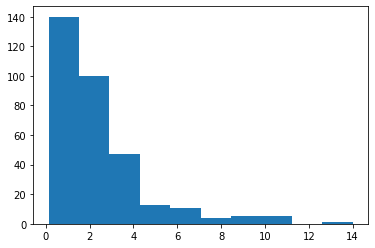

In [15]:
losss = np.array(losss)
print("Best pt on test set:\n")
print("Mean loss:\t", np.mean(losss))
print("Max loss:\t", np.max(losss))
print("Min loss:\t", np.min(losss))

plt.hist(losss)

In [24]:
idx = np.where(losss == 14.009904)[0][0]
print(idx)

212


In [28]:
print(idxs)

[ 41  60 172 181 212]


In [25]:
import os
testlist = os.listdir(str(testset))
print(testlist[idx])

240


### L1loss < 1 kcal/mol

40 0.34743163


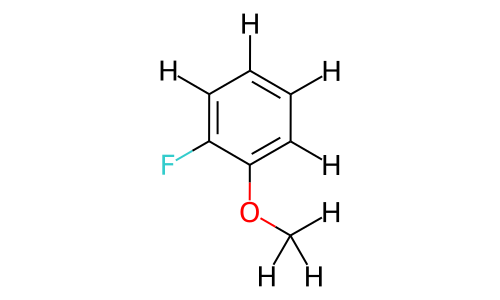

51 0.14062263


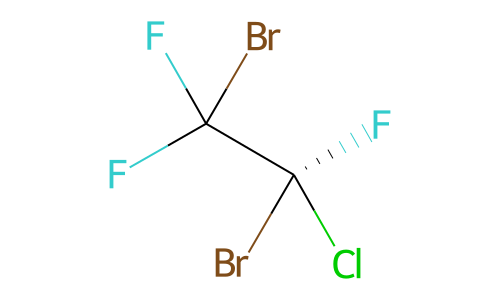

64 0.42267907


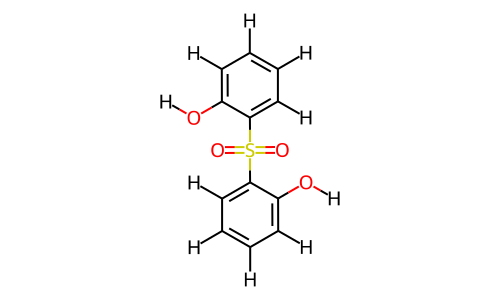

81 0.46423617


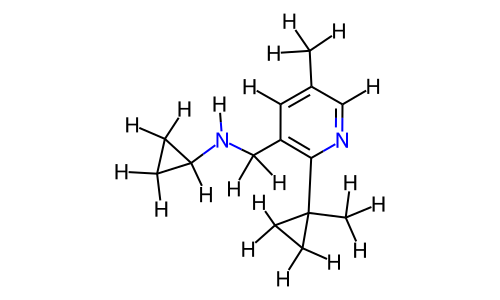

106 0.46602365


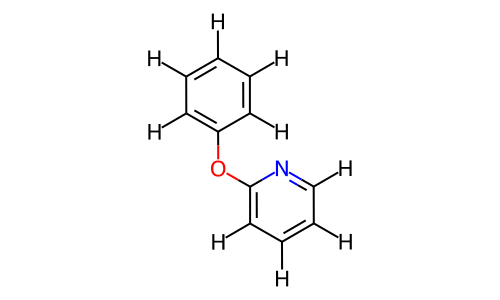

111 0.41373342


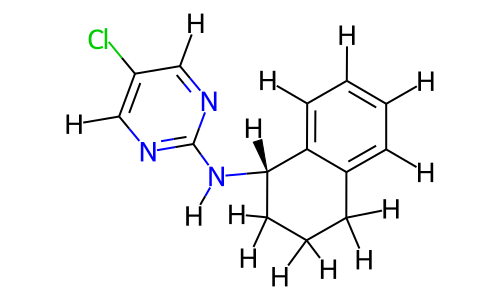

128 0.34098595


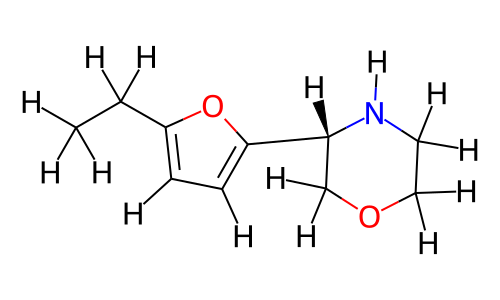

139 0.47122043


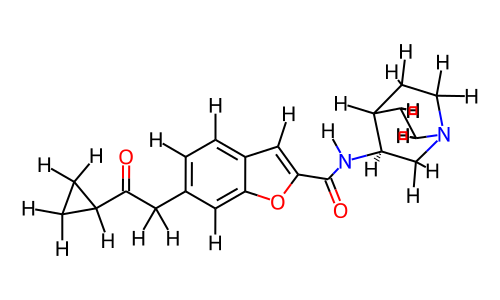

152 0.43012288


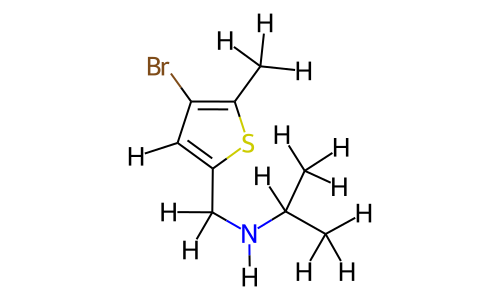

154 0.44851565


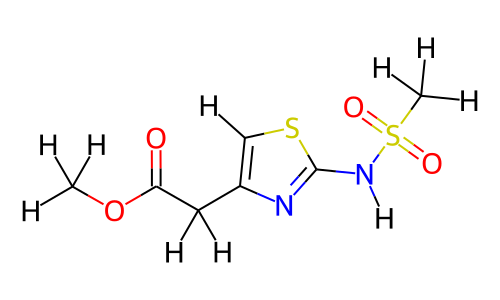

158 0.39907408


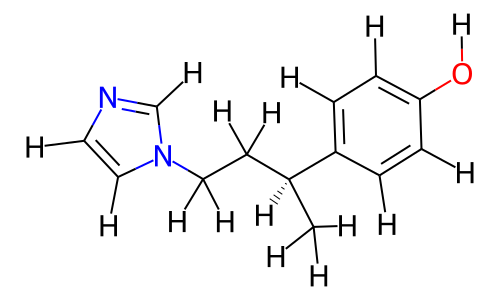

161 0.40974593


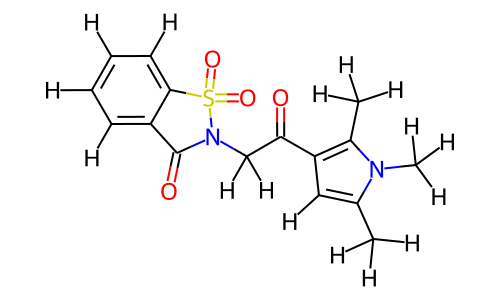

186 0.22695932


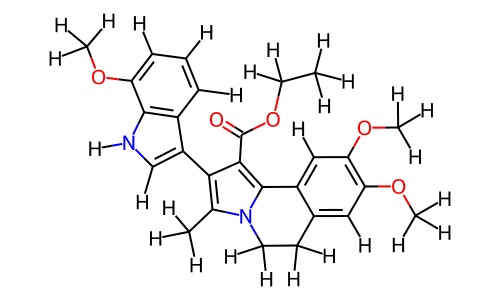

187 0.4956961


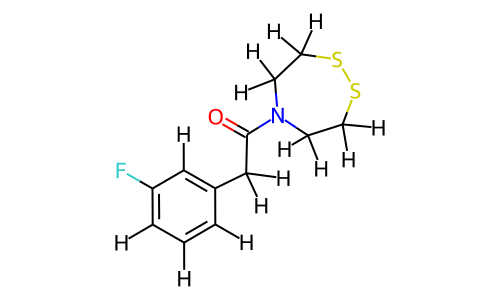

189 0.40806103


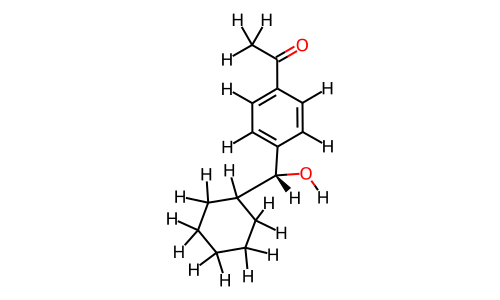

194 0.32218042


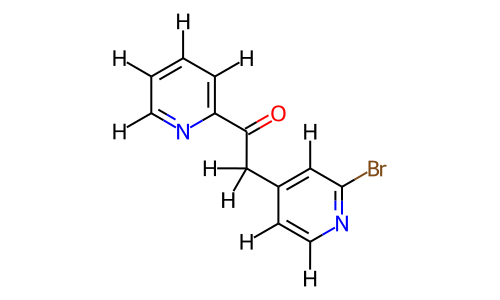

197 0.42776015


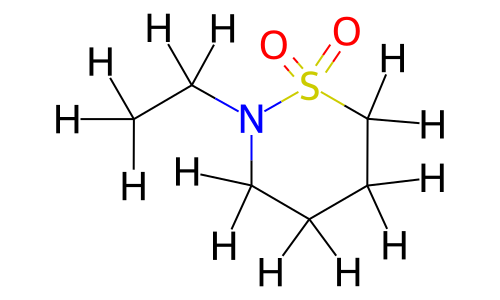

200 0.35354692


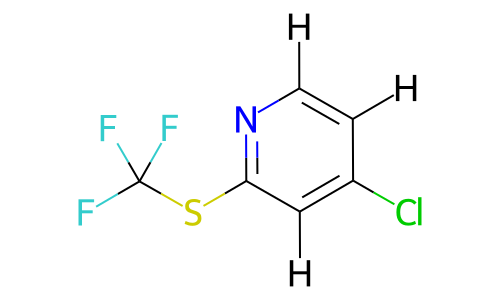

210 0.27980584


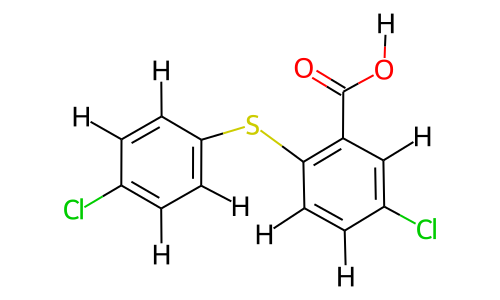

238 0.41166815


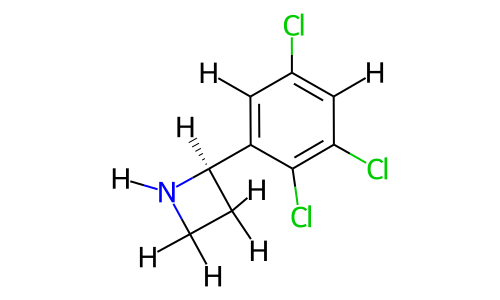

247 0.36544544


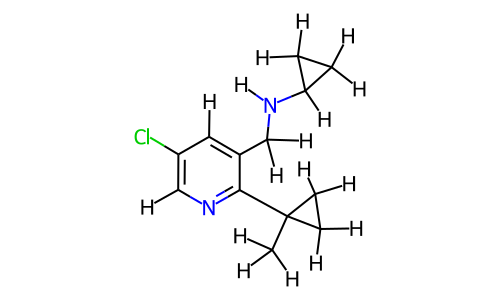

248 0.33873183


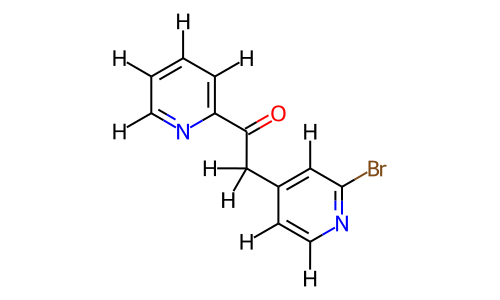

283 0.47860464


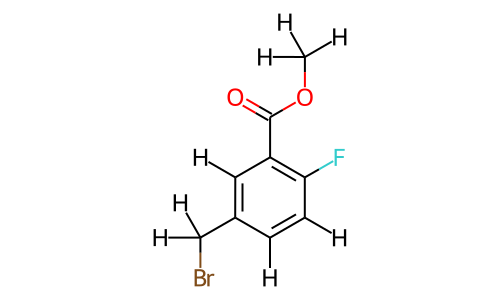

293 0.36536333


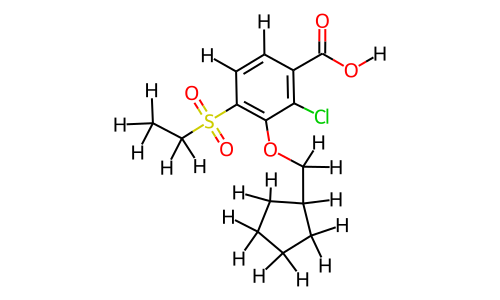

295 0.49308878


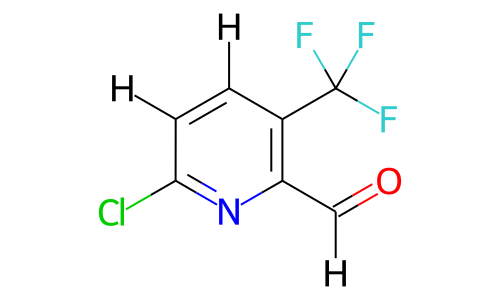

303 0.36540946


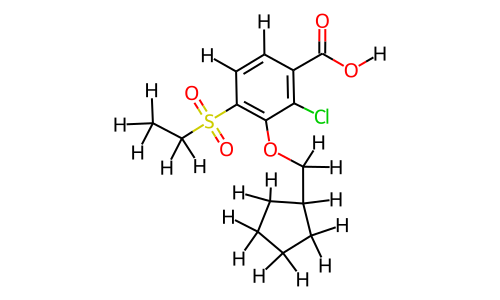

310 0.12970726


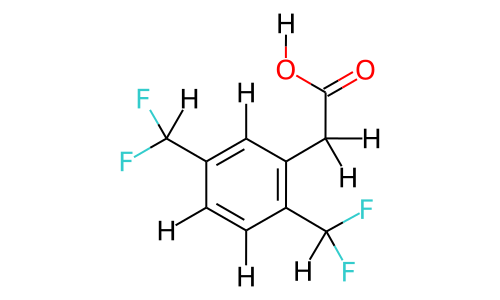

311 0.14551549


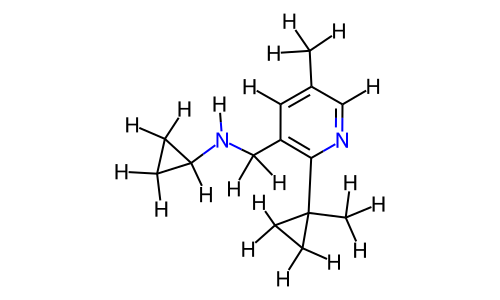

325 0.28476086


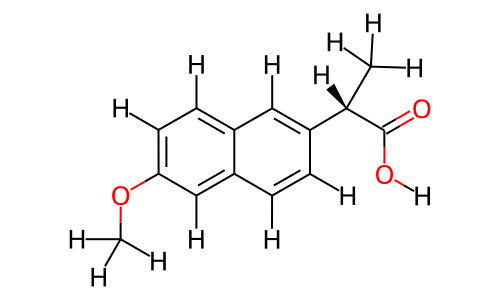

In [38]:
idxs = np.where(losss < 0.5)
# print(idxs)
for idx in idxs[0]:
    print(idx, losss[idx])
    display(ds_test[int(idx)].mol)

### L1loss > 10 kcal/mol

41 10.624803


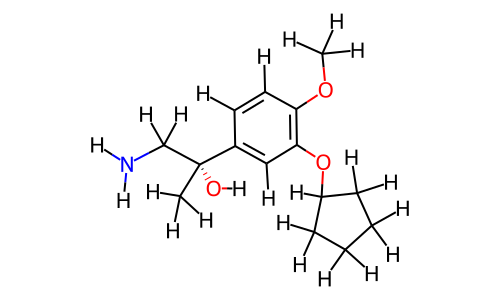

60 11.136704


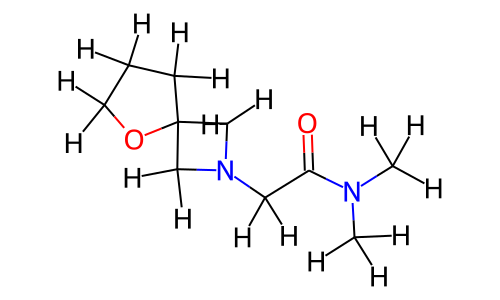

172 10.942197


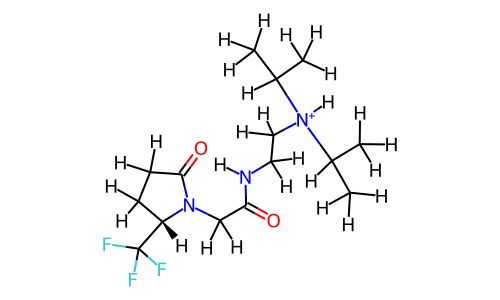

181 10.84505


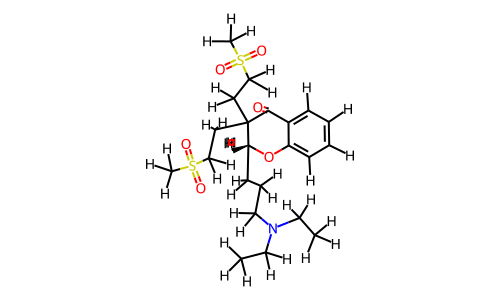

212 14.009904


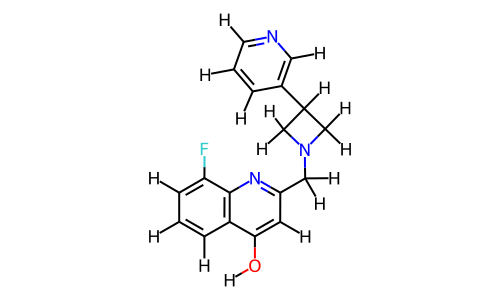

In [36]:

idxs = np.where(losss > 10)
for idx in idxs[0]:
    print(idx, losss[idx])
    display(ds_test[int(idx)].mol)
